In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from pathlib import Path
# Settings
sns.set_style("whitegrid")


Although the dataset provides both daily ('day.csv') and hourly ('hour.csv')
files, only the hourly dataset is used. Since the objective is to predict
hourly utilization, the daily dataset represents an aggregated version of
the same data and does not provide additional information at the required
granularity. Using the daily data could also introduce information leakage.

In [ ]:
DATA_DIR = Path("bike+sharing+dataset")
# Load day dataset
day_data = pd.read_csv(DATA_DIR/"day.csv")
day_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [26]:
# Load hourly dataset
hour_data = pd.read_csv(DATA_DIR / "hour.csv")
hour_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [27]:
# Dataset shape
hour_data.shape

(17379, 17)

In [28]:
hour_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [29]:
# check missing values 
hour_data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [36]:
hour_data['registered'].value_counts()

registered
4      307
3      294
5      287
6      266
2      245
      ... 
559      1
683      1
520      1
666      1
585      1
Name: count, Length: 776, dtype: int64

In [24]:
# As per documentation of dataset 
# instant: row identifier
# dteday: date already encoded via year/month/hour
# casual, registered: direct components of target (data leakage)

df = hour_data.drop(
    columns=["instant", "dteday", "casual", "registered"]
)
df.head()


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


Exploratory Data Analysis (EDA)

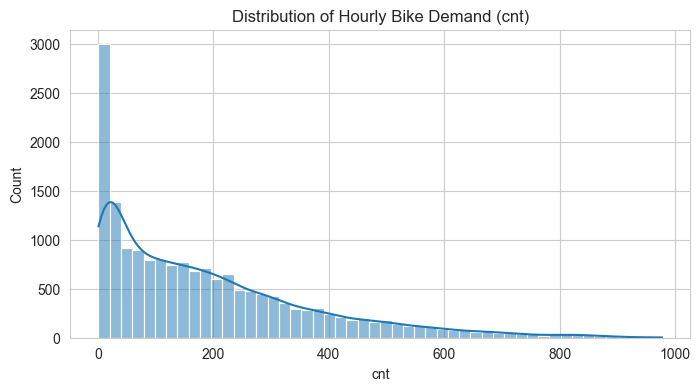

In [ ]:
#Distribution of hourly bike demand
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(df["cnt"], bins=50, kde=True, ax=ax)
ax.set_title("Distribution of Hourly Bike Demand (cnt)")
plt.show()


Above graph shows:
-Demand is right-skewed
-Majority of hours have low–moderate demand
-Some high-demand peak hours

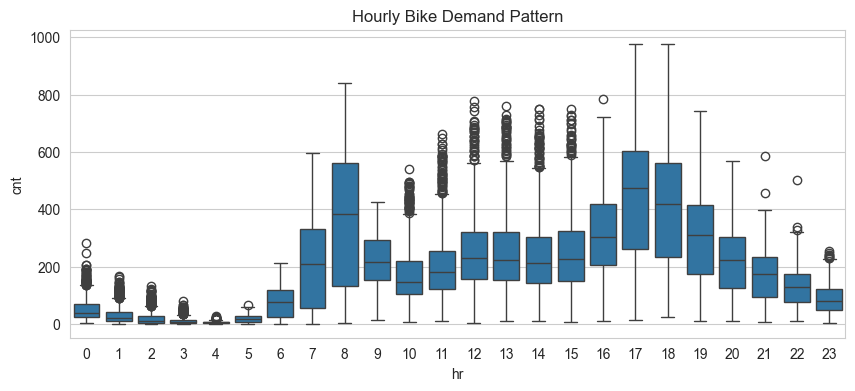

In [ ]:
#Hourly usage pattern
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x="hr", y="cnt", ax=ax)
ax.set_title("Hourly Bike Demand Pattern")
plt.show()


Above graph shows:
-Clear morning and evening peaks
-Hour of day is the strongest predictor

C:\Users\dawshr01\AppData\Local\Temp\ipykernel_29276\3942295476.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Working Day", "Working Day"])


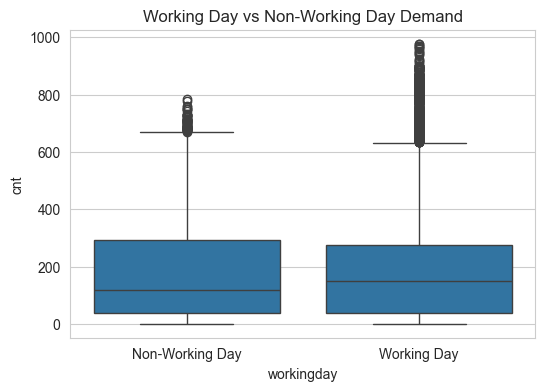

In [ ]:
# Working Day Effect
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x="workingday", y="cnt", ax=ax)
ax.set_title("Working Day vs Non-Working Day Demand")
ax.set_xticklabels(["Non-Working Day", "Working Day"])
plt.show()


Above graph shows
-Workdays show strong commute-driven usage
-Weekends have flatter distribution

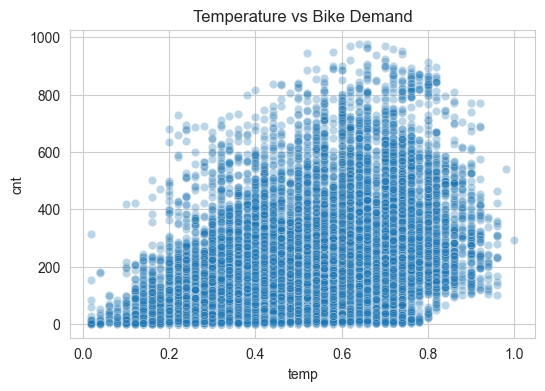

In [40]:
#temperature vs demand
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=df,
    x="temp",
    y="cnt",
    alpha=0.3,
    ax=ax
)
ax.set_title("Temperature vs Bike Demand")
plt.show()


In [42]:
# Feature Selection
FEATURES = [
    "season",
    "yr",
    "mnth",
    "hr",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed"
]

TARGET = "cnt"

X = df[FEATURES]
y = df[TARGET]


In [43]:
# Train/Test Split
# We are using Time-based split it Prevents future data leakage and Mimics real-world forecasting
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


In [56]:
# # Model Selection
model = RandomForestRegressor(
    n_estimators=700,
    max_depth=18,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)




,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",700
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",18
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [57]:
# Model Evaluation (Mean Absolute Deviation)
# Predictions
y_pred = model.predict(X_test)

# Mean Absolute Deviation
mad = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Deviation (MAD): {mad:.2f}")


Mean Absolute Deviation (MAD): 46.93


Typical hourly demand ranges from 0 to ~1000
Peak hours often have 300–800 bikes
So an error of 47 bikes means ~5–10% error during peak hours

In [58]:
# Feature Importance
feature_importance = (
    pd.Series(model.feature_importances_, index=FEATURES)
    .sort_values(ascending=False)
)

feature_importance


hr            0.628934
atemp         0.085710
temp          0.079512
yr            0.071326
workingday    0.057967
hum           0.021768
weathersit    0.015603
season        0.012910
weekday       0.010462
mnth          0.009876
windspeed     0.005011
holiday       0.000922
dtype: float64

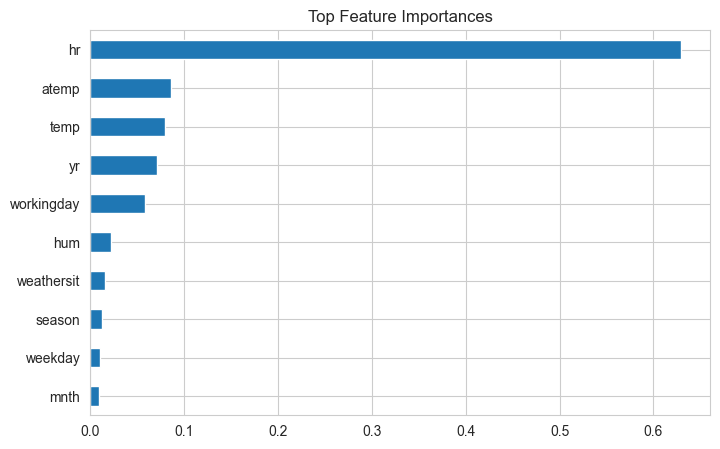

In [59]:
fig, ax = plt.subplots(figsize=(8, 5))
feature_importance.head(10).plot(kind="barh", ax=ax)
ax.set_title("Top Feature Importances")
ax.invert_yaxis()
plt.show()


## In your report, present only one model, that you think is most suitable for a business-case.Summarize your reasons for choosing this model. Report the mean absolute deviations.

### Model Selection
Selected Model: Random Forest Regressor
Only one model is used, as required.

Reasons for choosing Random Forest:
    -Captures non-linear relationships between features and demand
    -Handles feature interactions (e.g., hour × working day × weather)
    -Robust to noise and outliers in weather data
    -Requires minimal preprocessing
    -Provides feature importance, aiding interpretability
    -Low operational complexity compared to more advanced models

### Model Evaluation

The model was evaluated using Mean Absolute Deviation (MAD), which measures the average absolute difference between predicted and actual hourly demand.

Result: Mean Absolute Deviation (MAD) ≈ 47 bikes/hour

Interpretation: On average, the model’s hourly predictions deviate by approximately 47 bikes.
Given that peak hourly demand often reaches several hundred bikes, this level of error is acceptable for operational planning and decision support.

MAD was chosen because it is:
-Easy to interpret in business terms
-Less sensitive to outliers than squared-error metrics
-Aligned with real-world planning needs

## Assume that the code you are writing is used in production in a daily prediction service and maintained by your colleagues (what could that mean?)

If this model is used in a daily production system and maintained by other team members, the following points are important:

### Readable and simple code
    The code should be easy to understand, with clear variable names and comments, so that any colleague can maintain or modify it without confusion.
### Consistent input features
    The same input features used during training must also be used during prediction to avoid incorrect results.
### Reproducible results
    Fixed random seeds and defined library versions ensure that the model produces consistent results when retrained.
### Data quality checks
    Incoming data should be checked for missing values or incorrect weather inputs to prevent wrong predictions.
### Regular performance monitoring
    Model accuracy (for example, Mean Absolute Deviation) should be monitored to detect if prediction quality decreases over time.
### Scheduled retraining
    The model should be retrained periodically to adapt to seasonal changes and evolving user behavior.
### Version control
    Each model version should be saved so that changes can be tracked and previous versions can be restored if needed.